tensorflow version 2.6.0


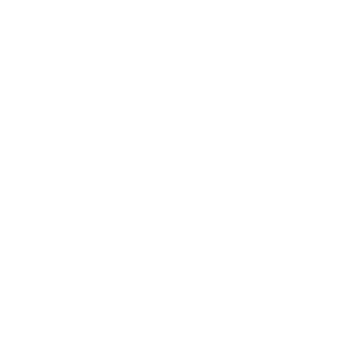

In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.signal
import soundfile as sp
import librosa
import pandas as pd
import librosa.display
from IPython.display import HTML
import IPython.display as ipd
import matplotlib.animation as animation
from sklearn.decomposition import  PCA,TruncatedSVD,FastICA
from inaSpeechSegmenter import Segmenter
from inaSpeechSegmenter.export_funcs import seg2csv, seg2textgrid
from utils import Preprocessing,Animation
from utils import Visualize
from dataloader import DataLoader
import random
import os
import config
from  pathlib  import Path 
print("tensorflow version" ,tf.__version__)
device = tf.config.list_physical_devices()[-1]

In [2]:
def applyfilter(y, pt = 0.1):
    # apply a 3-pole lowpass filter at 0.1x Nyquist frequency
    b, a = scipy.signal.butter(3, pt, 'low', analog=False)
    filtered = scipy.signal.filtfilt(b, a, y ,method="gust")
    return filtered

In [3]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 12
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

#We are initializing the experiment being analyzed
exp = config.experiment["NAME"]

In [4]:
pp =  Preprocessing(config.data['OUT_PATH'])

df =  pp.get_files()

# load some test data for demonstration and plot a wireframe
dl = DataLoader(config.data['file_path'],keepdims=True,make=True, crop_dims= (128,128) )
dl.load()

551 files read successfully


/net/store/cv/users/ybrima/miniconda3/envs/CV/lib/python3.9/site-packages/librosa/feature/spectral.py:2041: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


8439  1 second audio samples created successfully


In [5]:
def fancy_amplitude_envelope_overlap(signal,frame_size,hop_length):
    return np.array([max(signal[i:i+frame_size] )  for i in range(0,signal.size,hop_length) ])

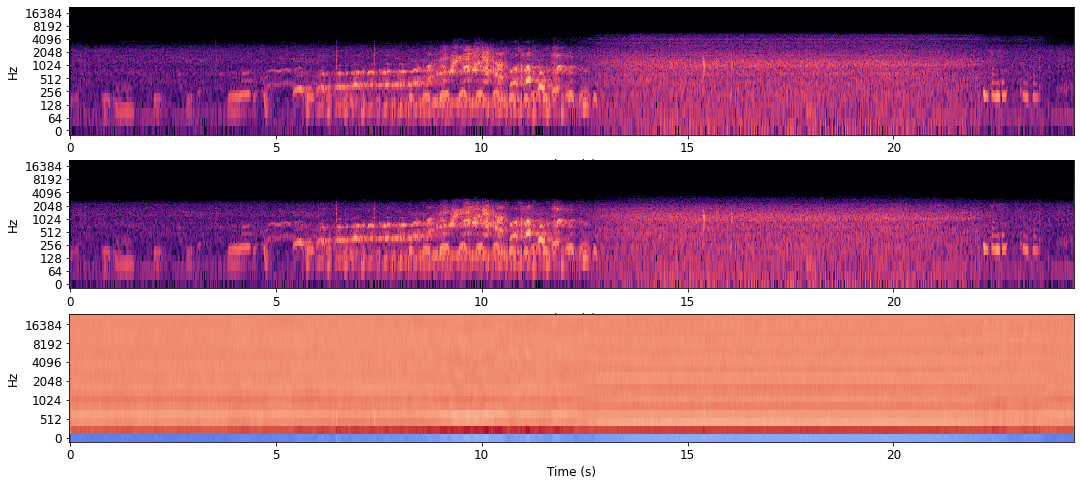

In [7]:
p = '/net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data/Full_Data/Converted/PAN'
pp = '/net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data/Full_Data/Cleaned/PAN'
files =  [f'{p}/{f}' for f in os.listdir(p)]
f = random.choice(files)
ff =  f'{pp}/{Path(f).name}'
y, sr =  librosa.load(f, sr = None)
yy, sr =  librosa.load(ff, sr = None)
# y = random.choice(dl.Z)
D = librosa.stft(applyfilter(y),hop_length=config.audio['HOP_LENGTH'], n_fft= config.audio['FRAME_LENGHT'])
D_scaled =  np.abs(D)**2
plt.figure(1, figsize=(18,8))
plt.subplot(311)
S_db = librosa.power_to_db(D_scaled, ref=np.max)
librosa.display.specshow(S_db,sr=config.audio['SAMPLE_RATE'],hop_length=config.audio['HOP_LENGTH'], x_axis='s', y_axis='log')
plt.subplot(312)
D = librosa.stft(applyfilter(yy),hop_length=config.audio['HOP_LENGTH'], n_fft= config.audio['FRAME_LENGHT'])
D_scaled =  np.abs(D)**2
S_db = librosa.power_to_db(D_scaled, ref=np.max)
librosa.display.specshow(S_db,sr=config.audio['SAMPLE_RATE'],hop_length=config.audio['HOP_LENGTH'], x_axis='s', y_axis='log')
plt.subplot(313)
mfcc = librosa.feature.mfcc(y= applyfilter(y),sr = config.audio['SAMPLE_RATE'],n_fft= config.audio['FRAME_LENGHT']//2, hop_length=config.audio['HOP_LENGTH'])
librosa.display.specshow(mfcc,sr=config.audio['SAMPLE_RATE'],hop_length=config.audio['HOP_LENGTH'], x_axis='s', y_axis='mel')
plt.show()

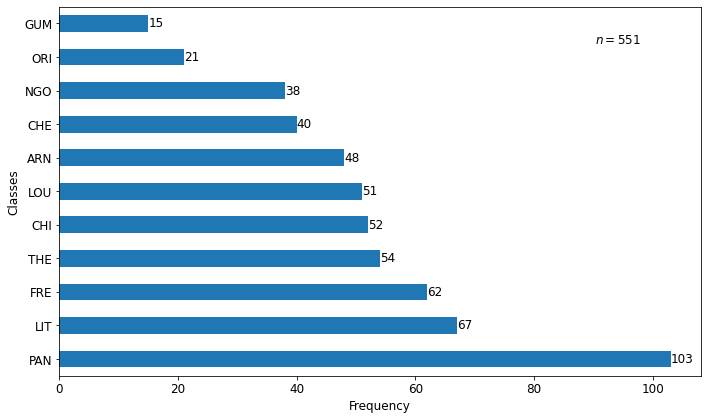

In [10]:
viz =  Visualize(config.figures['figpath'])
viz.show_distribution(df,save=True,filename=f'Data_Distribution_{exp}', figsize=(10,6))

In [19]:
n =  6
idx = np.random.randint(0, dl.X.shape[0], n)

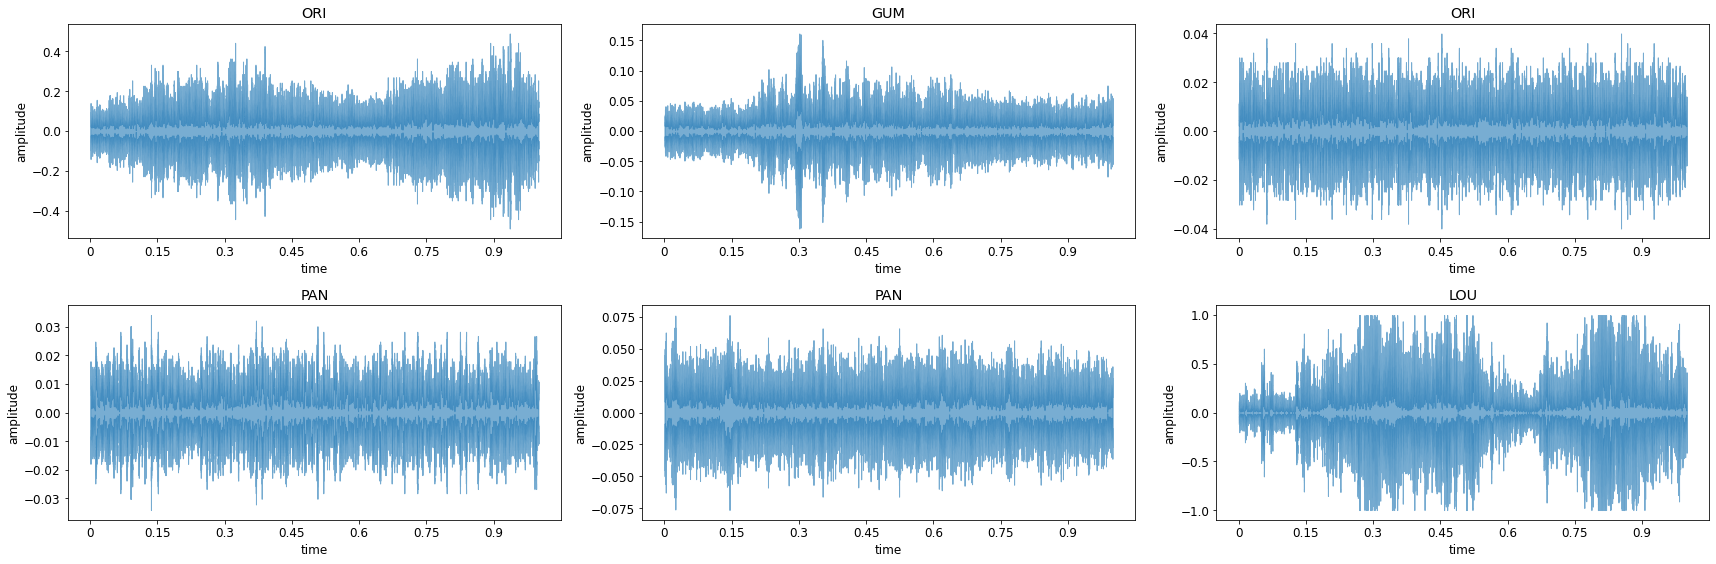

In [20]:
viz.display(dl.X,dl.Z,dl.y,dl.CLASSES,idx,filename=f'Sample_Waveplot_{exp}.png')

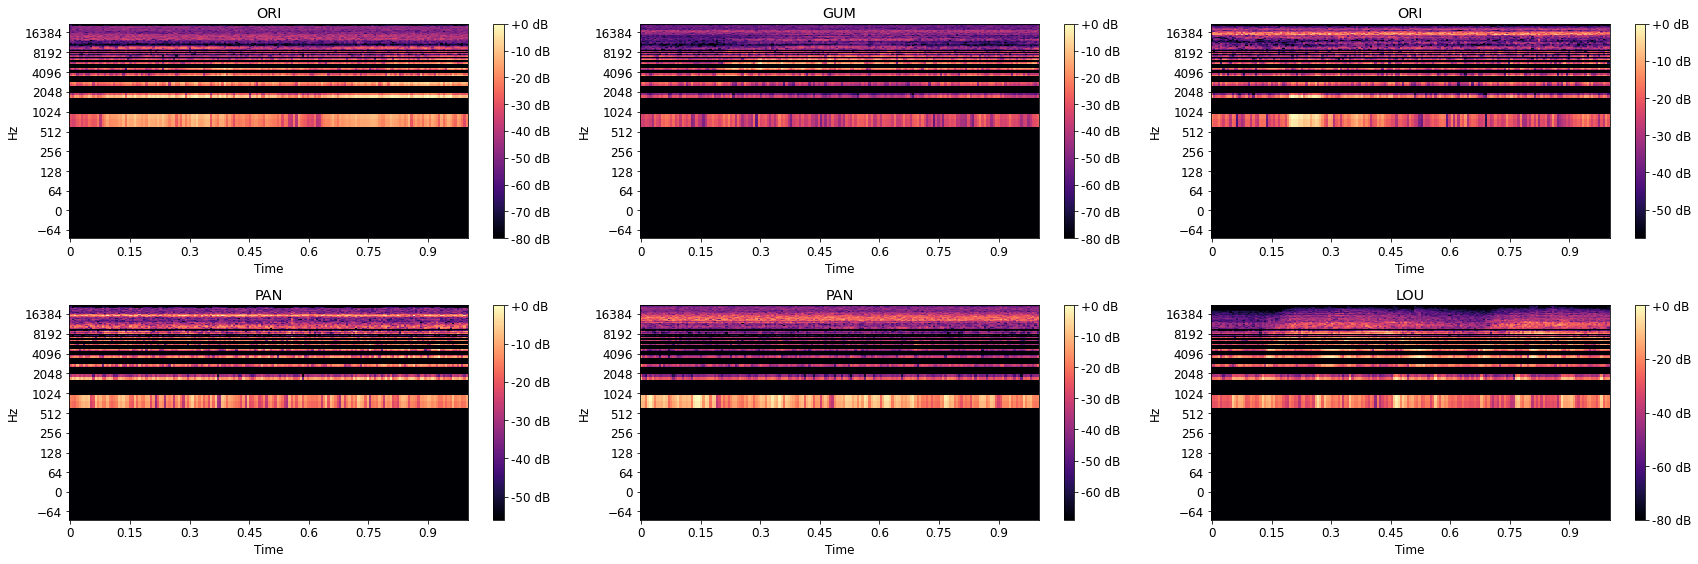

In [21]:
viz.display(dl.X,dl.Z,dl.y,dl.CLASSES,idx, flag=True,filename=f'UnNormalized_Frequency_Spectogram_{exp}.png')

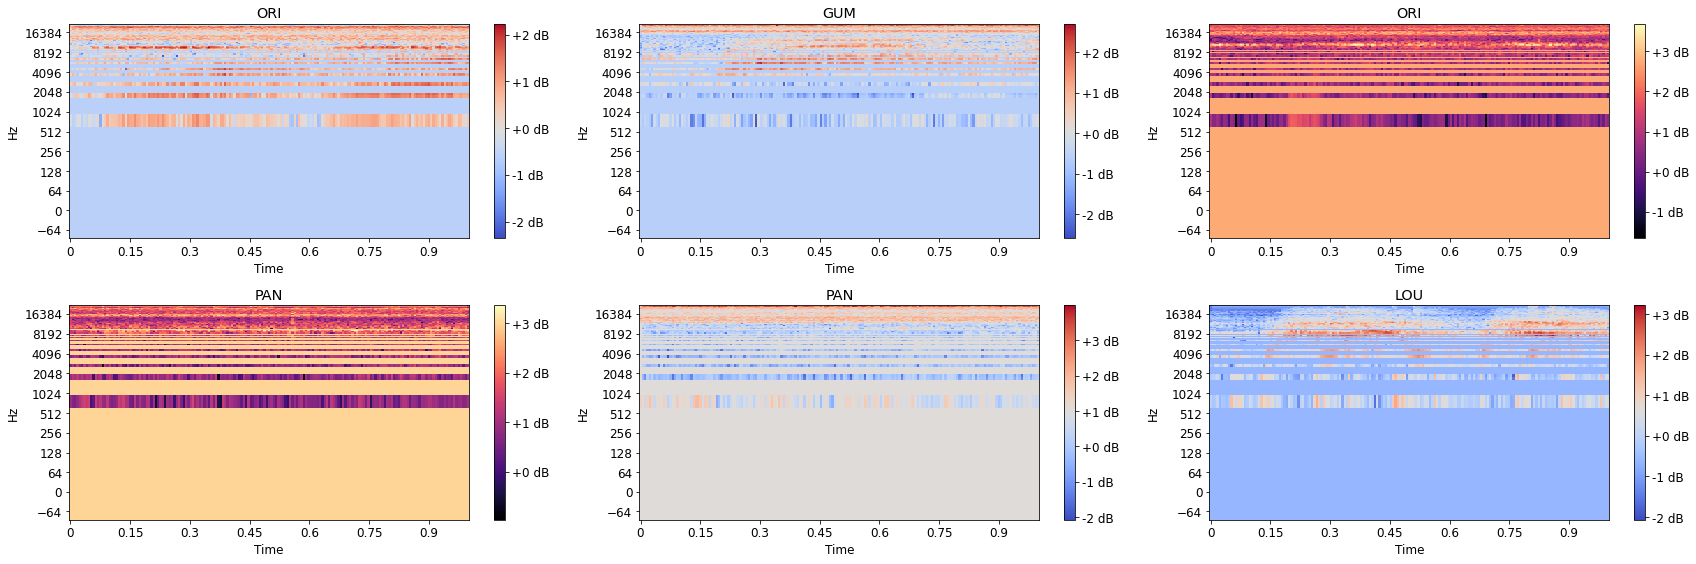

In [22]:
viz.display(dl.X_,dl.Z,dl.y,dl.CLASSES,idx, flag=True, save=True, filename=f'Normalized_Frequency_Spectogram_{exp}.png')

In [23]:
dl.project3D(PCA, n_components = 3)

 Successfully projected 128 to 3 dimensions using PCA


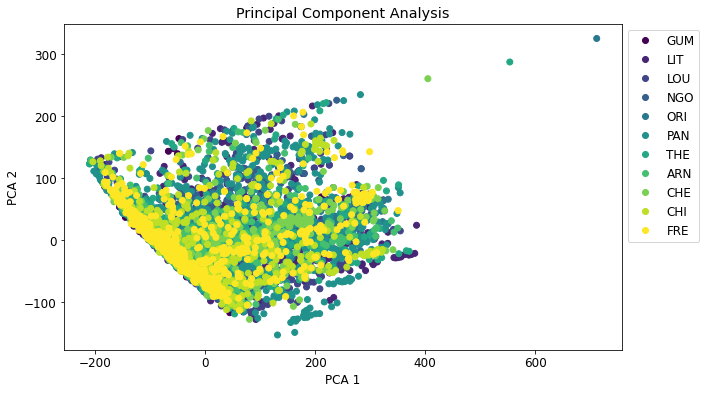

In [24]:
viz.plot_components(dl.X_projection,dl.y,dl.CLASSES,x_str='PCA 1', y_str='PCA 2', str_title="Principal Component Analysis", title=f"Normalized_PCA_{exp}.png")

In [27]:
dl.project3D(TruncatedSVD, n_components = 3)

 Successfully projected 129 to 3 dimensions using Tru


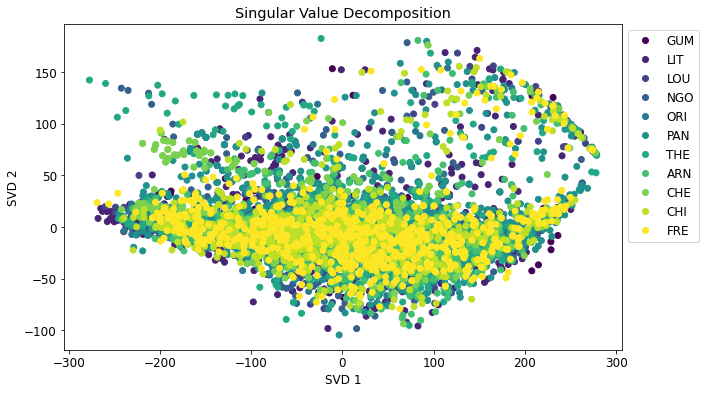

In [28]:
viz.plot_components(dl.X_projection,dl.y,dl.CLASSES,x_str='SVD 1', y_str='SVD 2', str_title="Singular Value Decomposition", title=f"Normalized_SVD_{exp}.png")

In [29]:
dl.project3D(FastICA, n_components = 3)

 Successfully projected 129 to 3 dimensions using Fas


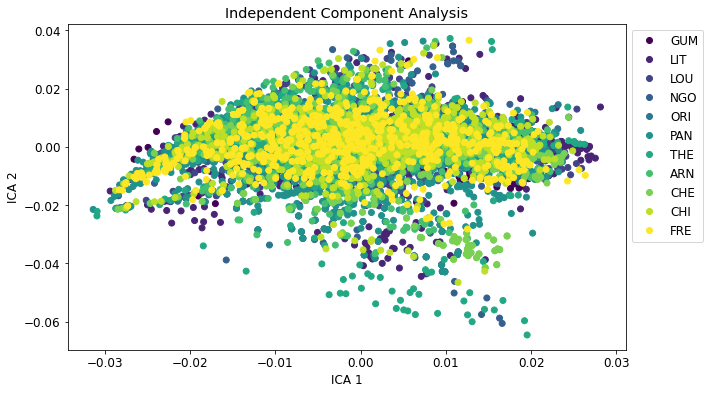

In [30]:
viz.plot_components(dl.X_projection,dl.y,dl.CLASSES,x_str='ICA 1', y_str='ICA 2', str_title="Independent Component Analysis", title=f"Normalized_ICA_{exp}.png")

In [31]:
dl.project3D(FastICA, n_components = 3)

 Successfully projected 129 to 3 dimensions using Fas


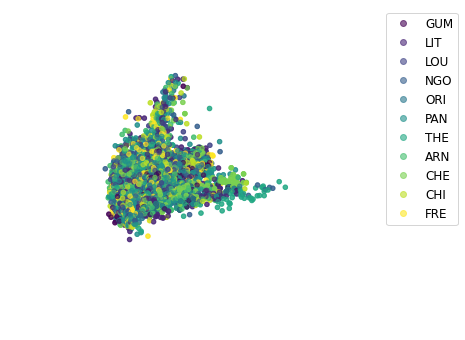

In [31]:
fig = plt.figure(1,figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()

def init():
    scatter = ax.scatter(dl.X_projection[:,0], dl.X_projection[:,1], dl.X_projection[:,2], c=list(dl.y),marker='o', s=20, alpha=0.6)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")
    ax.legend(handles=scatter.legend_elements()[0], labels=dl.CLASSES,bbox_to_anchor=(1.4, 1.0))
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=100, blit=True)    

HTML(ani.to_html5_video())

In [32]:
ani.save(f'./Figures/animation_ICA_{exp}.mp4',dpi=100,savefig_kwargs={'frameon': False,'pad_inches': 'tight'})
%cd Figures
!ffmpeg -i animation_ICA_Chimp.mp4 -filter:v fps=fps=60 animation_ICA_Chimp.gif
%cd ..

<ipython-input-32-66465b15df9a>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  ani.save(f'./Figures/animation_ICA_{exp}.mp4',dpi=100,savefig_kwargs={'frameon': False,'pad_inches': 'tight'})


/net/store/cv/users/ybrima/RTGCompCog/ChimCLR/Figures
ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/net/store/cv/users/ybrima/miniconda3/envs/CV --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.1

In [28]:
df  =  pd.read_csv('./Data/model_results_test_constant_epochs.csv')

In [29]:
df.head()

model      loss  accuracy  f1_score        time
0         vgg16  1.676976  0.650990  0.650990  521.276141
1         vgg19  1.639796  0.605198  0.605198  614.991054
2      resnet50  8.391062  0.579208  0.579208  627.425821
3  inception_v3  3.483990  0.293317  0.293317  761.099209
4      xception  1.028579  0.778465  0.778465  724.274714

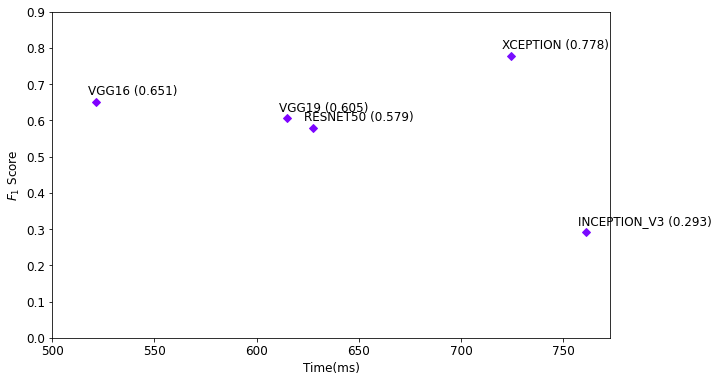

In [30]:
plt.figure(1,figsize=(10,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,df.shape[0],1)]
for i in range(df.shape[0]):
    plt.plot(df.iloc[i][-1],df.iloc[i][-2], marker='D', color=colors[i])
    plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][-2],3)})",(df.iloc[i][-1]-4.0,df.iloc[i][-2]+0.02),fontsize=12)
#     if(df.iloc[i][0] == 'xception'):
        
#     else:
#         plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][-2],3)})",(df.iloc[i][-1]-4.0,df.iloc[i][-2]-0.04),fontsize=12)
plt.yticks(np.arange(0, 1, .1))
plt.xticks(np.arange(500, 800,50))
plt.ylabel(r'$F_1$ Score')
plt.xlabel('Time(ms)')
# plt.grid()
plt.savefig(f'./Figures/Train_Time_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

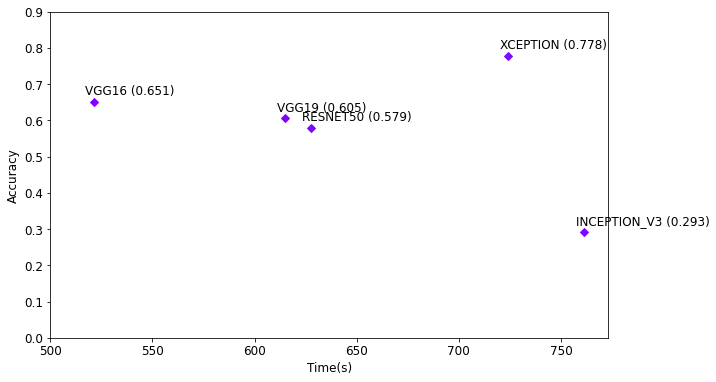

In [31]:
plt.figure(1,figsize=(10,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,df.shape[0],1)]
for i in range(df.shape[0]):
    plt.plot(df.iloc[i][-1],df.iloc[i][2], marker='D', color=colors[i])
    plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][2],3)})",(df.iloc[i][-1]-4.0,df.iloc[i][2]+0.02),fontsize=12)
plt.yticks(np.arange(0, 1, .1))
plt.xticks(np.arange(500, 800,50))
plt.ylabel('Accuracy')
plt.xlabel('Time(s)')
# plt.grid()
plt.savefig(f'./Figures/Train_Time_Accuracy_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

In [4]:
df  =  pd.read_csv('./Data/model_results_variable_test_time.csv')
df.head()

model      loss  accuracy  f1_score        time  second
0  vgg16  1.836432  0.663945  0.663945  685.198771     0.5
1  vgg16  2.184783  0.563119  0.563119  503.034150     1.0
2  vgg16  2.362159  0.436929  0.436929  447.783700     1.5
3  vgg16  2.053288  0.400480  0.400480  452.643404     2.0
4  vgg16  1.958313  0.343195  0.343195  433.076921     2.5

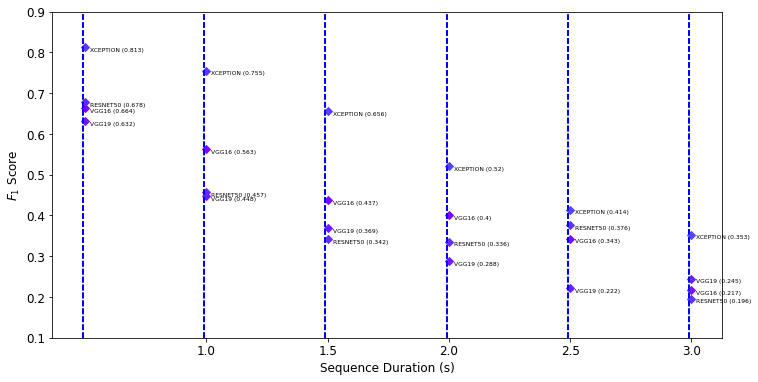

In [6]:
plt.figure(1,figsize=(12,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,df.shape[0],1)]
for i in range(df.shape[0]):
    plt.plot(df.iloc[i][-1],df.iloc[i][3], marker='D', color=colors[i])
    plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][3],3)})",(df.iloc[i][-1]+0.02,df.iloc[i][3] - 0.01),fontsize=6)
    plt.axvline(x=df.iloc[i][-1]-0.01, color='blue', linestyle='--')
plt.yticks(np.arange(0.1, 1, .1))
plt.xticks(np.arange(1, 3.5,0.5))
plt.ylabel(r'$F_1$ Score')
plt.xlabel('Sequence Duration (s)')
# plt.grid()
plt.savefig(f'./Figures/Sequence_Duration_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

In [36]:
df  =  pd.read_csv('./Data/model_results_test_variable_epochs.csv')
df.head()

model      loss  accuracy  f1_score         time  epoch
0  vgg16  1.399488  0.681931  0.681931   515.157474     20
1  vgg16  1.697860  0.704208  0.704208  1030.218887     40
2  vgg16  1.921375  0.727723  0.727723  1544.579646     60
3  vgg16  1.653170  0.714109  0.714109  2057.485389     80
4  vgg16  1.631113  0.696782  0.696782  2571.080408    100

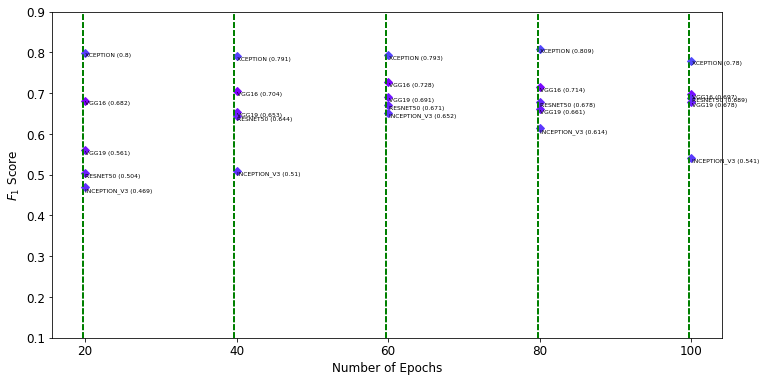

In [49]:
plt.figure(1,figsize=(12,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,df.shape[0],1)]
for i in range(df.shape[0]):
    plt.plot(df.iloc[i][-1],df.iloc[i][3], marker='D', color=colors[i])
    plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][3],3)})",(df.iloc[i][-1]+0.04,df.iloc[i][3]-0.01),fontsize=6)
    plt.axvline(x=df.iloc[i][-1]-0.3, color='green', linestyle='--')
plt.yticks(np.arange(0.1, 1, .1))
plt.xticks(np.arange(20, 110,20))
plt.ylabel(r'$F_1$ Score')
plt.xlabel('Number of Epochs')
# plt.grid()
plt.savefig(f'./Figures/Sequence_Duration_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

In [57]:
df  =  pd.read_csv('./Data/model_results_test_variable_batchsize.csv')
df.head()

model      loss  accuracy  f1_score        time   bs
0  vgg16  1.448479  0.534653  0.534653  514.164817    8
1  vgg16  1.582812  0.622525  0.622525  508.970493   16
2  vgg16  1.531949  0.621287  0.621287  508.792416   32
3  vgg16  1.375976  0.579208  0.579208  506.222214   64
4  vgg16  1.509854  0.594059  0.594059  509.496099  128

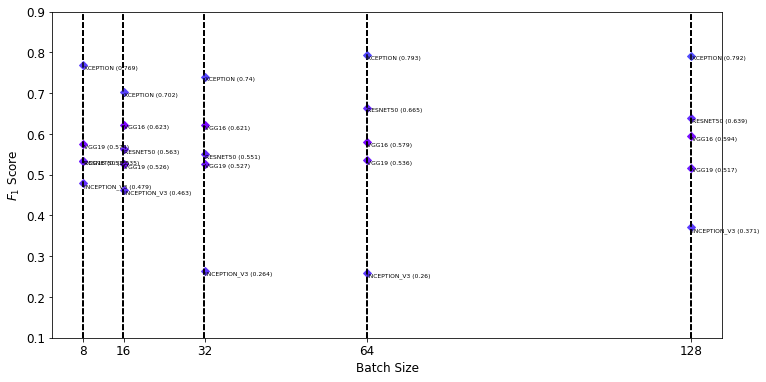

In [60]:
plt.figure(1,figsize=(12,6))
colors = [plt.cm.rainbow(x) for x in np.arange(0,df.shape[0],1)]
for i in range(df.shape[0]):
    plt.plot(df.iloc[i][-1],df.iloc[i][3], marker='D', color=colors[i])
    plt.annotate(fr"{df.iloc[i][0].upper()} ({np.round(df.iloc[i][3],3)})",(df.iloc[i][-1]+0.06,df.iloc[i][3] - 0.01),fontsize=6)
    plt.axvline(x=df.iloc[i][-1]-0.1, color='k', linestyle='--')
plt.yticks(np.arange(0.1, 1.0, .1))
plt.xticks([2**x for x in range(3, 8)])
plt.ylabel(r'$F_1$ Score')
plt.xlabel('Batch Size')
# plt.grid()
plt.savefig(f'./Figures/Sequence_Batch_Size_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

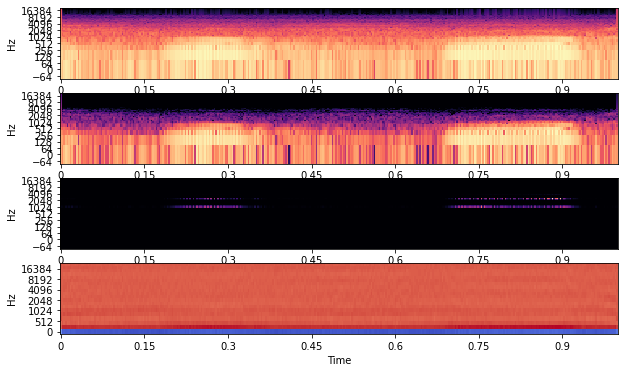

In [124]:
y = random.choice(dl.Z)
HOP_SIZE = config.audio['HOP_LENGTH']//4
N_FFT = config.audio['FRAME_LENGHT']//4
D = librosa.stft(applyfilter(y),hop_length=HOP_SIZE, n_fft= N_FFT)
D_scaled =  np.abs(D)
plt.figure(1, figsize=(10,6))
plt.subplot(411)
S_db = librosa.power_to_db(D_scaled, ref=np.max)
librosa.display.specshow(S_db,sr=config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, x_axis='time', y_axis='log')
plt.subplot(412)
D = librosa.stft(applyfilter(y),hop_length=HOP_SIZE, n_fft= N_FFT)
D_scaled =  np.abs(D)**2
S_db = librosa.power_to_db(D_scaled, ref=np.max)
librosa.display.specshow(S_db,sr=config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, x_axis='time', y_axis='log')
plt.subplot(413)
S = librosa.feature.melspectrogram(y=y, sr=config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, n_fft= N_FFT, n_mels=128,fmax=8000)
librosa.display.specshow(S,sr=config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, x_axis='time', y_axis='log')
plt.subplot(414)
mfcc = librosa.feature.mfcc(y= applyfilter(y),sr = config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, n_fft= N_FFT)
librosa.display.specshow(mfcc,sr=config.audio['SAMPLE_RATE'],hop_length=HOP_SIZE, x_axis='time', y_axis='mel')
plt.show()

In [135]:
bs = [2**x for x in range(3, 8)]
bs

[8, 16, 32, 64, 128]